<a href="https://colab.research.google.com/github/Userfound404/GSoC-QMLHEP-Tasks/blob/main/QMLHEP_GSoC'24_Task_VIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task VIII
Vision transformer/Quantum Vision Transformer
Implement a classical Vision transformer and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical vision transformer architecture to a quantum vision transformer and sketch out the architecture in detail.


In [ ]:
!pip install torch torchvision einops tqdm scikit_learn


In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
from einops.layers.torch import Rearrange
from torchvision.datasets import MNIST
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim, nhead=8), num_layers=6)
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embedding(x)
        x = x.flatten(2).transpose(1, 2)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.positional_embedding
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 7202209.33it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 28828104.19it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 5046081.16it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4530446.79it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:09<00:00,  4.96it/s]


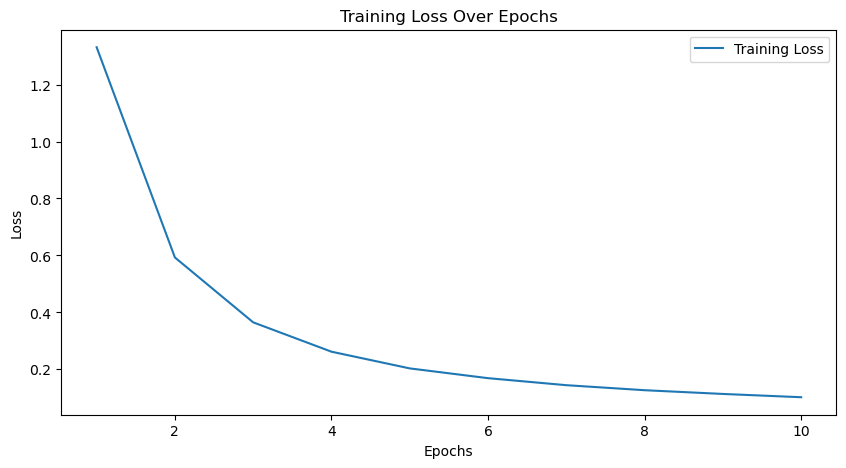

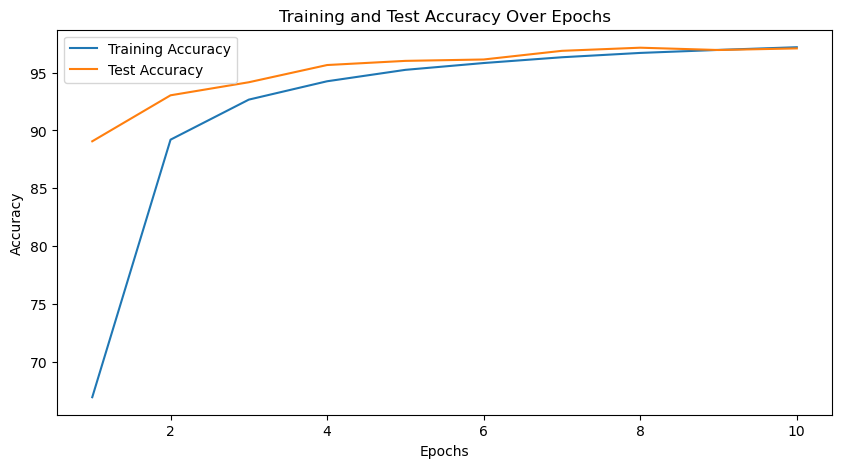

Precision: 0.97
Recall: 0.97
F1 Score: 0.97


In [ ]:
model = VisionTransformer(image_size=28, patch_size=7, num_classes=10, dim=64)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Test evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)

# Plotting the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

# Calculate additional metrics
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate additional metrics
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


In [ ]:
class ResNetModifiedFirstLayer(models.ResNet):
    def __init__(self):
        super(ResNetModifiedFirstLayer, self).__init__(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], num_classes=10)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Instantiate the modified ResNet model
resnet_model = ResNetModifiedFirstLayer()

# Move model to device
resnet_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
resnet_train_losses = []
resnet_train_accuracies = []
resnet_test_accuracies = []



In [ ]:
for epoch in range(num_epochs):
    resnet_model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_accuracy = 100 * correct / total
    resnet_train_losses.append(train_loss / len(train_loader))
    resnet_train_accuracies.append(train_accuracy)

    # Test evaluation
    resnet_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct / total
    resnet_test_accuracies.append(test_accuracy)

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [05:37<00:00,  2.78it/s]


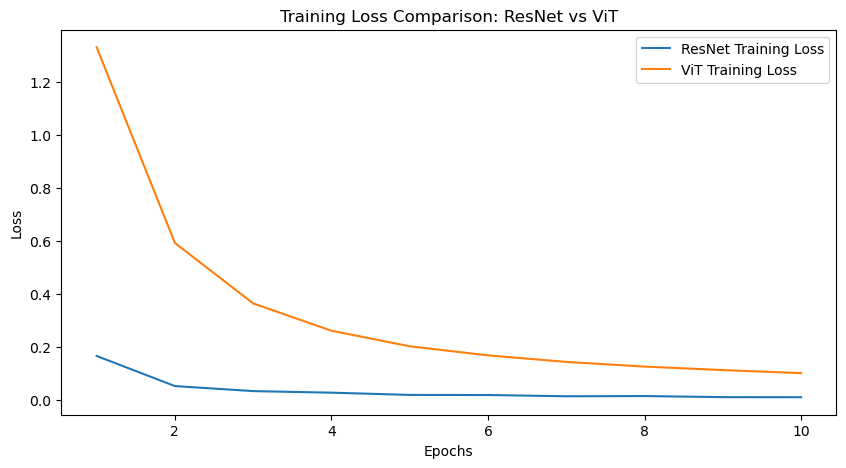

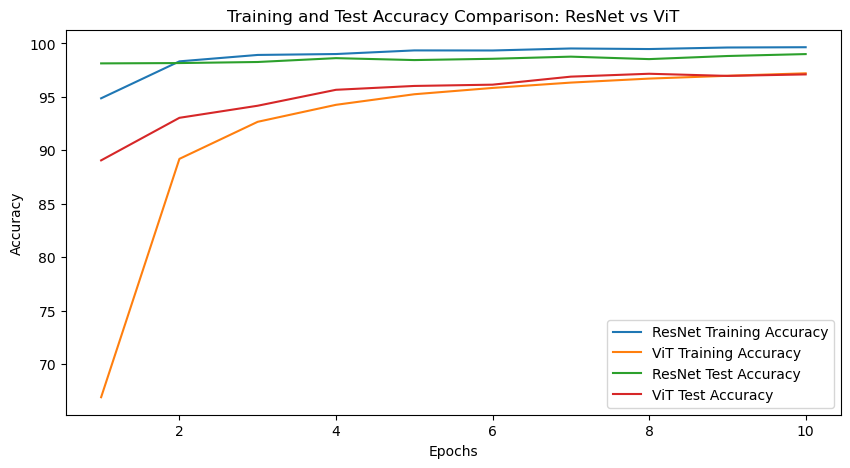

In [ ]:
# Plotting the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, resnet_train_losses, label='ResNet Training Loss')
plt.plot(epochs, train_losses, label='ViT Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: ResNet vs ViT')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, resnet_train_accuracies, label='ResNet Training Accuracy')
plt.plot(epochs, train_accuracies, label='ViT Training Accuracy')
plt.plot(epochs, resnet_test_accuracies, label='ResNet Test Accuracy')
plt.plot(epochs, test_accuracies, label='ViT Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Comparison: ResNet vs ViT')
plt.legend()
plt.show()


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
lenet_model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer_lenet = optim.Adam(lenet_model.parameters(), lr=0.001)

def train_model_with_loss_tracking(model, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []  # List to track accuracy

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0  # Track correct predictions within epoch
        total = 0  # Track total samples within epoch

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Accuracy calculation
            _, predicted = outputs.max(1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate and print loss and accuracy
        average_epoch_loss = epoch_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(average_epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    return train_losses, train_accuracies

In [ ]:
lenet_losses = train_model_with_loss_tracking(lenet_model, optimizer_lenet)

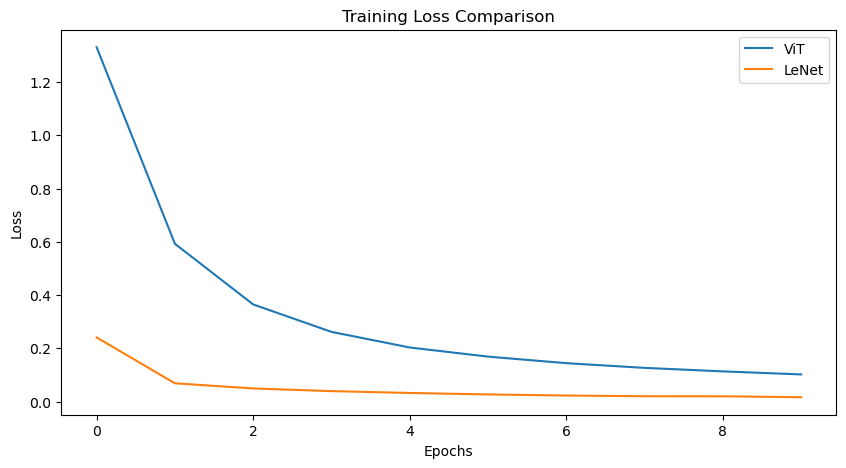

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='ViT')
plt.plot(lenet_losses, label='LeNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

In [ ]:
# Modify VisionTransformer class to increase model depth
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        encoder_layers = nn.TransformerEncoderLayer(d_model=dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=depth)
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embedding(x)
        x = x.flatten(2).transpose(1, 2)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.positional_embedding
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

# Train the modified model
modified_model = VisionTransformer(image_size=28, patch_size=7, num_classes=10, dim=64, depth=12)
optimizer_modified = optim.Adam(modified_model.parameters(), lr=1e-4)
train_model_with_loss_tracking(modified_model, optimizer_modified)
modified_accuracy = evaluate_model(modified_model)
print("Modified Vision Transformer Accuracy:", modified_accuracy)


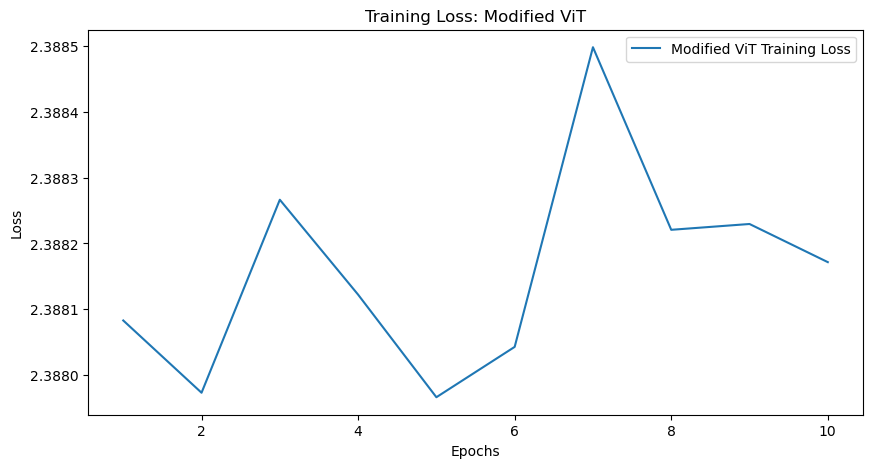

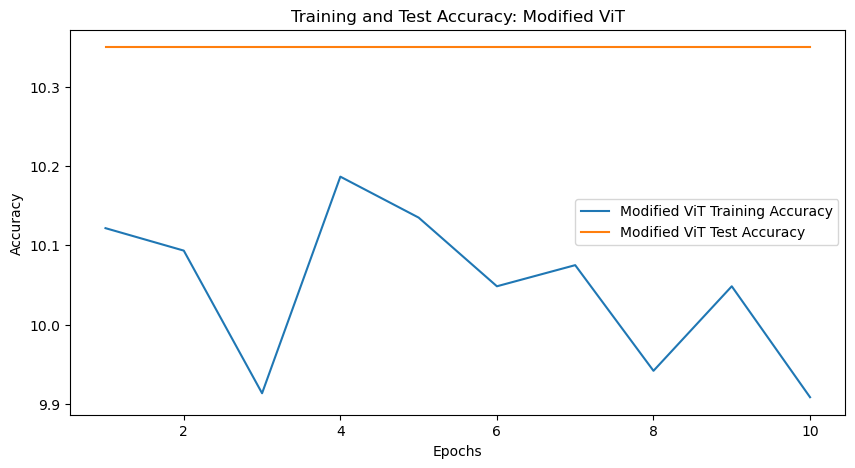

In [ ]:
plt.figure(figsize=(12, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), modified_vit_train_losses, label='Modified ViT Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), modified_vit_test_accuracies, label='Modified ViT Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()

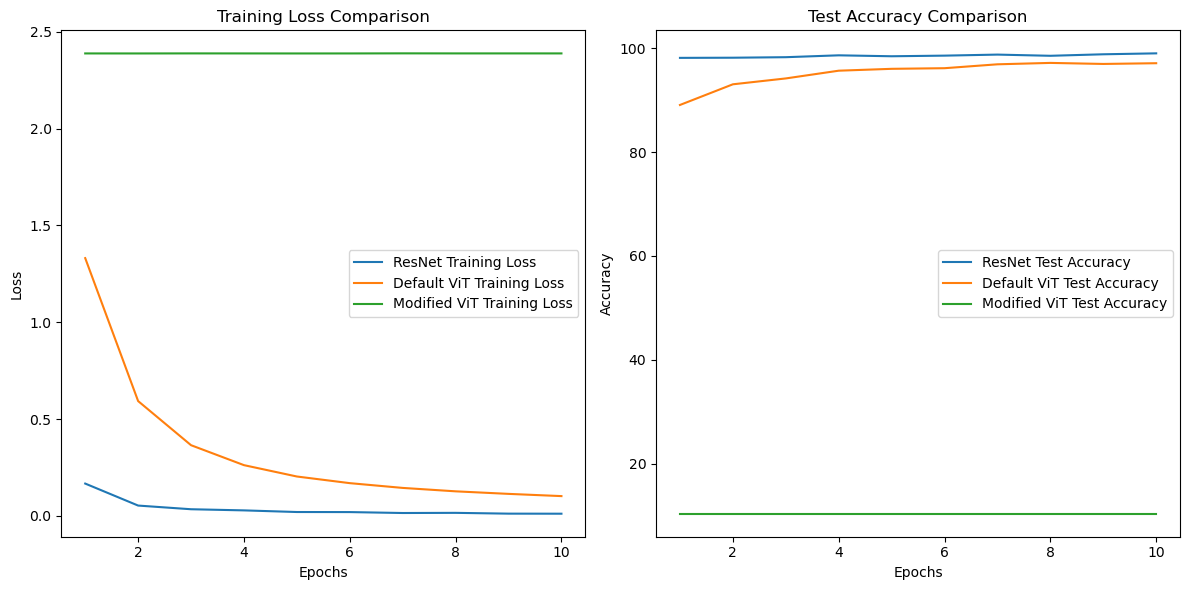

In [ ]:
# Plotting the metrics for comparison
plt.figure(figsize=(12, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, resnet_train_losses, label='ResNet Training Loss')
plt.plot(epochs, train_losses, label='Default ViT Training Loss')
plt.plot(epochs, modified_vit_train_losses, label='Modified ViT Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, resnet_test_accuracies, label='ResNet Test Accuracy')
plt.plot(epochs, test_accuracies, label='Default ViT Test Accuracy')
plt.plot(epochs, modified_vit_test_accuracies, label='Modified ViT Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Data augmentation transforms
transform_augmented = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Augmented dataset
train_dataset_augmented = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_augmented)
train_loader_augmented = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)


In [ ]:
# Modify VisionTransformer class to include dropout and weight decay
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, num_heads, dropout_rate=0.1):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        encoder_layers = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=6)
        self.fc = nn.Linear(dim, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.patch_embedding(x)
        x = x.flatten(2).transpose(1, 2)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.positional_embedding
        x = self.dropout(x)  # Apply dropout
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

# Initialize and train the model with dropout and weight decay
model_with_regularization = VisionTransformer(image_size=28, patch_size=7, num_classes=10, dim=64, num_heads=8, dropout_rate=0.1)
optimizer_regularization = optim.Adam(model_with_regularization.parameters(), lr=1e-4, weight_decay=1e-5)
train_model_with_loss_tracking(model_with_regularization, optimizer_regularization)


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:27<00:00,  4.53it/s]


Epoch 1/10, Loss: 1.4502, Accuracy: 62.30%


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:29<00:00,  4.47it/s]


Epoch 2/10, Loss: 0.6782, Accuracy: 87.22%


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:44<00:00,  4.18it/s]


Epoch 3/10, Loss: 0.4235, Accuracy: 91.25%


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:39<00:00,  4.28it/s]


Epoch 4/10, Loss: 0.3044, Accuracy: 93.18%


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:30<00:00,  4.45it/s]


Epoch 5/10, Loss: 0.2377, Accuracy: 94.34%


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:43<00:00,  4.19it/s]


Epoch 6/10, Loss: 0.1993, Accuracy: 95.02%


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:43<00:00,  4.19it/s]


Epoch 7/10, Loss: 0.1712, Accuracy: 95.52%


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:44<00:00,  4.19it/s]


Epoch 8/10, Loss: 0.1496, Accuracy: 95.99%


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:45<00:00,  4.16it/s]


Epoch 9/10, Loss: 0.1353, Accuracy: 96.31%


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [03:37<00:00,  4.32it/s]


Epoch 10/10, Loss: 0.1250, Accuracy: 96.49%


NameError: name 'evaluate_model' is not defined

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

test_accuracy = evaluate_model(model, test_loader)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 97.1


In [ ]:
!pip install timm

In [ ]:
import timm

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Load pre-trained Vision Transformer
pretrained_model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Freeze transformer encoder layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Modify the classification head for MNIST
pretrained_model.head = nn.Linear(in_features=pretrained_model.head.in_features, out_features=10)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)

# Define optimizer for fine-tuning
optimizer_ft = optim.Adam(pretrained_model.head.parameters(), lr=1e-4)

# Define loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# Fine-tune the model
num_epochs = 5
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    pretrained_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_ft.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_accuracies.append(epoch_acc)

    # Evaluation on test set
    pretrained_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_test_acc = correct / total
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Test Accuracy: {epoch_test_acc:.4f}")

# Print final accuracies
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████| 938/938 [5:00:49<00:00, 19.24s/it]


Epoch 1/5, Loss: 0.7889, Train Accuracy: 0.8248, Test Accuracy: 0.9171


100%|██████████████████████████████████████████████████████████████████████████████| 938/938 [5:02:28<00:00, 19.35s/it]


Epoch 2/5, Loss: 0.3186, Train Accuracy: 0.9253, Test Accuracy: 0.9389


100%|██████████████████████████████████████████████████████████████████████████████| 938/938 [4:58:13<00:00, 19.08s/it]


Epoch 3/5, Loss: 0.2357, Train Accuracy: 0.9399, Test Accuracy: 0.9436


100%|██████████████████████████████████████████████████████████████████████████████| 938/938 [4:55:17<00:00, 18.89s/it]


Epoch 4/5, Loss: 0.1965, Train Accuracy: 0.9473, Test Accuracy: 0.9517


100%|██████████████████████████████████████████████████████████████████████████████| 938/938 [4:42:08<00:00, 18.05s/it]


Epoch 5/5, Loss: 0.1725, Train Accuracy: 0.9524, Test Accuracy: 0.9545
Final Train Accuracy: 0.9524
Final Test Accuracy: 0.9545


In [ ]:
pretrained_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9545


## Quantum Vision Transformers by El Amine Cherrat et. al.


The paper discusses Quantum Vision Transformers, focusing on extending classical transformer neural network architectures for natural language processing and image analysis to the quantum domain

1. **Quantum Vision Transformer (QVT)** - This architecture extends the classical vision transformer to the quantum domain. It incorporates a quantum attention mechanism, enabling it to process image data efficiently.

2. **Quantum Language Transformer (QLT)** - is designed for natural language processing tasks. It leverages quantum circuits to handle language-related computations, such as token embeddings and self-attention.

3. **Quantum Hybrid Transformer (QHT)** - The QHT combines elements of both QVT and QLT. It aims to address multi-modal tasks that involve both image and text data. By integrating quantum attention mechanisms with classical transformer components.








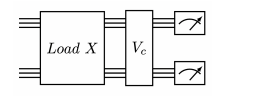

We have two parts, to execute one attention layer of the comppound transformer.

We use matrix data loader for $X$ and a quantum orthogonal layer for $V_c$ applied on both registers

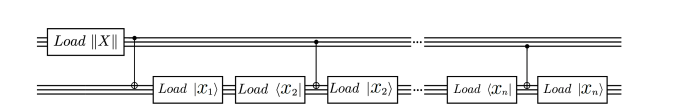

This is the data loader for a matrix $X ∈ ℝ^{n * d}$.
The top register uses N qubits and the vector data loader is used to load the norms of each row.

Each loaded on the lower register has depth $O(log d) .s$

The quantum layer with parameterised circuits $V_c$ is built with
RBS gates, given by

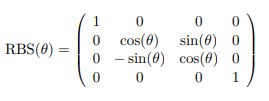

Which can be implemented by four Hadamard gates, two two-qubit $CZ$ gates and two $R_y$ gates.

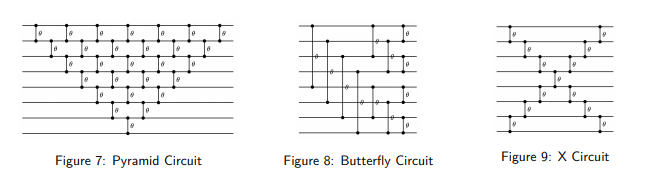

These are the different circuits used in the orthogonal layers.
